<h3>File written by David Benisty and Denitsa Staicova</h3> If you use it or parts of it, please cite <a href="https://arxiv.org/abs/2009.10701"> arXiv:2009.10701 [astro-ph.CO]</a><br>
Title: OmegaK-CDM v.1 <br>
Last update: 15.12.2020

In [1]:
                                                                                                                                        from numpy import pi, log, sqrt
import emcee
import getdist
import numpy as np
from io import StringIO 
from getdist import plots, MCSamples
import random
from scipy.integrate import quad
from scipy.integrate import odeint
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy import stats 
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, GaussianPrior
import scipy.optimize as op
from numpy.linalg import inv
from mpi4py import MPI

In [2]:
# load Cosmic Chronometers dataset
ccData = np.genfromtxt("./BAO/CC.txt")
# load Pantheon dataset
panthData = np.genfromtxt("./BAO/binned_data.txt")
panthData = panthData[np.argsort(panthData[:,1])]
# load GRB dataset
GRBData = np.genfromtxt("./BAO/GRB.txt")
# load Quzars
QuData = np.genfromtxt("./BAO/Quasars.txt")


#loading BAO data
dirBD= "./BAO/uncorBAO.txt"
#dirDJ= "./BAO/data.txt"
BaoData = np.genfromtxt(dirBD)
xarr = np.array(BaoData[:,0])    
yarr = np.array(BaoData[:,1])
dyarr = np.array(BaoData[:,2])

funarr = np.genfromtxt(dirBD,dtype='str')[:,3]
print(funarr)

def modelArr(name):
    mod = []

    for j in range(len(funarr)):
        if (funarr[j] == name):
             mod.append([xarr[j],yarr[j],dyarr[j]])
    mod = np.array(mod)
    mod = mod[np.argsort(mod[:,0])]
    return mod

['DVratio' 'DVratio' 'DArd' 'rdDV' 'DVratio' 'DArd' 'DVratio' 'Hxrd'
 'DVrd' 'rdDV' 'DHrd' 'rdDV' 'rdDV' 'rdDV' 'DHrd' 'DAratio' 'DAratio']


In [3]:
#H functions
c = 299792.458

def E(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    return np.sqrt(np.abs(Om*(1+z)**3 + Ol + Ok*(1+z)**2+(1 - Om - Ol - Ok)*(1+z)**4))

def H(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(H0*E(theta,z[j]))
    arr = np.array(arr)
    return arr

def Hxrd(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(rd*H0*E(theta,z[j]))
    arr = np.array(arr)
    return arr

def Hxratio(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(H0*E(theta,z[j])*rat)
    arr = np.array(arr)
    return arr

Hxratio([67,0.007,0.31,0.67,150,1],[1,2,3])

array([123.28728239, 213.51881416, 327.88953933])

In [4]:
#DH functions
def DH(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])))
    arr = np.array(arr)
    return arr

def DHrd(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    arr = []
    
    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])*rd))
    arr = np.array(arr)
    return arr

DHrd([67,0.007,0.31,0.67,150,1],[1,2,3])

array([16.21105071,  9.36037601,  6.09539539])

In [5]:
def Sk(theta,x):
    H0, Ok, Om, Ol, rd, rat = theta
    if Ok < -10**(-15):
        return np.sin(np.sqrt(-Ok)*x)/np.sqrt(-Ok)
    #if Ok == 0:
    #    return x
    elif Ok > 10**(-15):
        return np.sinh(np.sqrt(Ok)*x)/np.sqrt(Ok)
    else:
        return x

In [6]:
# function that returns dDC/dz,df/dz
def dchidz(x,z, H0, Ok, Om, Ol, rd, rat):
    return 1/E([H0, Ok, Om, Ol, rd, rat],z)

def chiInt(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    z = np.hstack((np.array((0)), z))
    arr = odeint(dchidz,0,z,args=(H0, Ok, Om, Ol, rd, rat,))
    return np.delete(arr ,0)

chiInt([67,0.007,0.31,0.67,150,1],[1,2,3])

array([0.75518797, 1.16872242, 1.42173239])

In [7]:
#DM 

def DM(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/H0)
    arr = np.array(arr)
    arr.shape
    return arr

def DMrd(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rd))
    arr = np.array(arr)
    arr.shape
    return arr

def DMratio(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rat))
    arr = np.array(arr)
    arr.shape
    return arr

DMratio([67,0.007,0.31,0.67,150,1],[1,2,3])

array([3381.34812834, 5237.80263671, 6376.5744424 ])

In [8]:
#DA 

def DA(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*(z[i]+1)))
    arr = np.array(arr)
    arr.shape
    return arr

def DArd(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rd*(z[i]+1)))
    arr = np.array(arr)
    arr.shape
    return arr

def DAratio(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    chi = chiInt(theta,z)
    
    arr = []
    
    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rat*(z[i]+1)))
    arr = np.array(arr)
    arr.shape
    return arr

DAratio([67,0.007,0.31,0.67,150,1],[1,2,3])

array([1690.67406417, 1745.93421224, 1594.1436106 ])

In [9]:
#DV 

def DV(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2))
    arr = np.array(arr)
    arr.shape
    return arr

def DVrd(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta 
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2)/rd)
    arr = np.array(arr)
    arr.shape
    return arr

def DVratio(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2)/rat)
    arr = np.array(arr)
    arr.shape
    return arr

def rdDV(theta,z):
    H0, Ok, Om, Ol, rd, rat = theta
    dh = DH(theta,z)  
    dm = DM(theta,z)
    arr = []
    
    for i in range(len(z)):
        arr.append(rd/(np.cbrt(z[i]*dh[i]*dm[i]**2)))
    arr = np.array(arr)
    arr.shape
    return arr

rdDV([67,0.007,0.31,0.67,150,1],[1,2,3])

array([0.04951429, 0.03525226, 0.0311622 ])

In [10]:
def mu(theta,z):
    DL = DM(theta,z)    
    mu = []
    
    for i in range(len(z)):
        mu.append(5*np.log10(DL[i]*(1+z[i])))
    mu = np.array(mu)
    mu.shape
    return mu

In [11]:
def lnlike(theta, model,x,y,dy):
    num = len(x)
    chi2 = 0 
    
    prediction = model(theta,x)
    for i in range(len(x)):
        chi2 += ((prediction[i]-y[i])/dy[i])**2
    return chi2

def lnlikeCC(theta):
    chi = 0; i = 0
    chi += lnlike(theta,H,ccData[:,0], ccData[:,1], ccData[:,2]); i += len(ccData[:,0])
    return -chi, [i, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta)))]

print(lnlikeCC([67,0.007,0.31,0.67,150,1]))

(-14.775753990198728, [30, 0.6156564162582804, 0.9271488970070771])


In [12]:
# biuld the covariance matrix
def covFromErr(error):
    num = len(error)
    cov = np.zeros((num,num))
    for j in range(num):
        cov[j,j] = error[j]**2
    return inv(cov)

def randCov(list_length,error):
    num = len(error)
    cov = np.zeros((num,num))
    for j in range(num):
        cov[j,j] = error[j]**2
    # the covariance matrix for the uncorrelated data
    randomList = random.sample(range(len(error)), list_length)
    for i in range(len(randomList)):
        for j in range(len(randomList)):
            if (i!=j):
                cov[i,j] += 0.5*error[i]*error[j]               
    return inv(cov)

In [13]:
# likelihood with covariance matrix
def lnlikecov(theta,model,x,y,cov):
    chi2 = 0 
    prediction = []
    #x = x*np.ones(len(model))
    for i in range(len(model)):
        fun = model[i]
        prediction.append(eval(fun)(theta,[x[i]]))
    prediction = np.array(prediction)[:,0]
    prediction.shape
    vec = (prediction - y)
    
    result = np.dot(np.dot(vec,cov),vec.T)
    return result

numUn = 0

print(lnlikecov([67,0.007,0.31,0.67,150,1],funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),covFromErr(np.array(BaoData[:,2]))))
print(lnlikecov([67,0.007,0.31,0.67,150,1],funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),randCov(numUn,np.array(BaoData[:,2]))))

25.728502243478285
25.728502243478285


In [14]:
def lnlikeBAO(theta):
    chi =  lnlikecov(theta,funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),covFromErr(np.array(BaoData[:,2]))) 
    i = len(BaoData[:,0])
    return -chi, [chi, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta)))]

lnlikeBAO([68,0.007,0.31,0.68,147,0.9])

(-83.60622240180729,
 [83.60622240180729, 7.600565672891571, 2.949862576429041e-13])

In [59]:
#The likelihood functions
def A(theta, x, y, yerr):
    chi2 = 0
    Mu = mu(theta,x)
    for i in range(len(x)):
        chi2 += (y[i] - Mu[i])**2/yerr[i]**2
    return chi2

def B(theta, x, y, yerr):
    chi2 = 0
    Mu = mu(theta,x)
    for i in range(len(x)):
        chi2 += (y[i] - Mu[i])/yerr[i]**2
    return chi2

def C(theta, x, y, yerr):
    chi2 = 0
    for i in range(len(x)):
        chi2 += 1/yerr[i]**2
    return chi2

def chiTyIA(theta, x, y, yerr):
    return (A(theta, x, y, yerr) - B(theta, x, y, yerr)**2/C(theta, x, y, yerr))

def lnlikeHubb(theta):
    chi = chiTyIA(theta,panthData[:,1], panthData[:,4], panthData[:,5])
    chi += chiTyIA(theta,GRBData[:,2],GRBData[:,3],GRBData[:,4])
    chi += chiTyIA(theta,QuData[:,0],QuData[:,1],QuData[:,2])
    i = len(panthData[:,1]) + len(GRBData[:,2]) + len(QuData[:,0])
    return -chi, [chi, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta)))]

print(lnlikeHubb([68,0.007,0.31,0.68,147,0.9]))

(-236.52448168485716, [236.52448168485716, 1.0751112803857144, 0.21172029961563565, 226])


In [60]:
def lnlikeTot(theta):
    chi =  lnlikecov(theta,funarr,np.array(BaoData[:,0]),np.array(BaoData[:,1]),covFromErr(np.array(BaoData[:,2]))) 
    i = len(BaoData[:,0])
    chi += lnlike(theta,H,ccData[:,0], ccData[:,1], ccData[:,2]); i += len(ccData[:,0])  
    chi += chiTyIA(theta,panthData[:,1], panthData[:,4], panthData[:,5])
    chi += chiTyIA(theta,GRBData[:,2],GRBData[:,3],GRBData[:,4])
    chi += chiTyIA(theta,QuData[:,0],QuData[:,1],QuData[:,2])
    i += len(panthData[:,1]) + len(GRBData[:,2]) + len(QuData[:,0]) 
    return -chi, [chi, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta)))]

print(lnlikeTot([68,0.007,0.31,0.68,147,0.9]))

(-334.66185189271516, [334.66185189271516, 1.2534151756281466, 0.0030708211840181354, 273])


In [17]:
runs = 100

In [18]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [19]:
def uniprior(hypercube):
    prior = []
    prior.append(UniformPrior(50.,100.)(hypercube[0]))
    prior.append(UniformPrior(-0.1,0.1)(hypercube[1])) #k
    prior.append(UniformPrior(0.1,1.-hypercube[1])(hypercube[2]))
    prior.append(UniformPrior(0.,1-hypercube[2])(hypercube[3]))
    prior.append(UniformPrior(100,200)(hypercube[4]))
    prior.append(UniformPrior(0.9,1.1)(hypercube[5]))
    return prior

def unipriorRiess(hypercube):
    prior = []
    prior.append(GaussianPrior(74.03,1.42)(hypercube[0]))
    prior.append(UniformPrior(-0.1,0.1)(hypercube[1])) #k
    prior.append(UniformPrior(0.1,1.-hypercube[1])(hypercube[2]))
    prior.append(UniformPrior(0.,1-hypercube[2])(hypercube[3]))
    prior.append(UniformPrior(100,200)(hypercube[4]))
    prior.append(UniformPrior(0.9,1.1)(hypercube[5]))
    return prior

In [21]:
settingsBAO = PolyChordSettings(6,3)
settingsBAO.file_root = 'LCDMBAO_OmkNcS100'
settingsBAO.nlive = runs
settingsBAO.do_clustering = True
settingsBAO.read_resume = False

settingsBAOR = PolyChordSettings(6,3)
settingsBAOR.file_root = 'LCDMBAOR_OmkNcS100'
settingsBAOR.nlive = runs
settingsBAOR.do_clustering = True
settingsBAOR.read_resume = False

settingsHDR = PolyChordSettings(6,3)
settingsHDR.file_root = 'LCDMHDR_OmkNcS100'
settingsHDR.nlive = runs
settingsHDR.do_clustering = True
settingsHDR.read_resume = False

settingsTot = PolyChordSettings(6,3)
settingsTot.file_root = 'LCDMTot_OmkNcS100'
settingsTot.nlive = runs
settingsTot.do_clustering = True
settingsTot.read_resume = False

settingsTotR = PolyChordSettings(6,3)
settingsTotR.file_root = 'LCDMTotR_OmkNcS100'
settingsTotR.nlive = runs
settingsTotR.do_clustering = True
settingsTotR.read_resume = False

In [22]:
outputBAO = pypolychord.run_polychord(lnlikeBAO, 6,3, settingsBAO, uniprior, dumper)

Last dead point: [ 6.27219328e+01 -1.25442620e-02  3.20475737e-01  4.85047285e-01
  1.97582476e+02  1.07692992e+00  2.70438992e+03  2.45853629e+02
  0.00000000e+00 -8.42828112e+03 -2.70438992e+03]
Last dead point: [ 5.10053128e+01  3.11903329e-03  2.22000933e-01  5.22466580e-01
  1.75993777e+02  9.06967485e-01  1.14852272e+03  1.04411157e+02
  0.00000000e+00 -1.29837824e+03 -1.14852272e+03]
Last dead point: [ 5.74354293e+01 -8.95875830e-03  3.72476665e-01  2.75331061e-01
  1.24401807e+02  1.01545966e+00  7.16544666e+02  6.51404242e+01
  0.00000000e+00 -1.14783422e+03 -7.16544666e+02]
Last dead point: [ 8.81658692e+01 -2.00124319e-02  1.66325082e-01  8.53384834e-01
  1.44512705e+02  1.02423033e+00  4.26664665e+02  3.87876969e+01
  0.00000000e+00 -7.17649726e+02 -4.26664665e+02]
Last dead point: [ 6.40105326e+01  1.82800854e-02  1.84422770e-01  6.77414639e-01
  1.49886224e+02  9.20617107e-01  2.56064267e+02  2.32785697e+01
  0.00000000e+00 -3.21760926e+02 -2.56064267e+02]
Last dead point

In [23]:
outputBAOR = pypolychord.run_polychord(lnlikeBAO, 6,3, settingsBAOR, unipriorRiess, dumper)

Last dead point: [ 7.48370156e+01 -3.39414201e-02  6.22991693e-01  1.18202215e-02
  1.25125453e+02  9.55331175e-01  2.77358544e+03  2.52144131e+02
  0.00000000e+00 -3.24730157e+03 -2.77358544e+03]
Last dead point: [ 7.40182576e+01  5.01314565e-02  2.00109593e-01  2.49397868e-01
  1.05188959e+02  9.60988686e-01  1.38944064e+03  1.26312785e+02
  0.00000000e+00 -5.59756806e+03 -1.38944064e+03]
Last dead point: [ 7.68224126e+01  3.84543575e-02  1.62950772e-01  4.91654813e-01
  1.01720154e+02  9.01339134e-01  6.68750381e+02  6.07954892e+01
  0.00000000e+00 -7.63829504e+02 -6.68750381e+02]
Last dead point: [ 7.27855313e+01  4.79308428e-02  1.08003457e-01  8.37395729e-01
  1.41320732e+02  9.59352954e-01  3.16445034e+02  2.87677304e+01
  0.00000000e+00 -4.24256341e+02 -3.16445034e+02]
Last dead point: [ 7.55446975e+01 -3.24912860e-02  1.19360081e-01  8.34047469e-01
  1.27069814e+02  1.03431770e+00  1.50283461e+02  1.36621328e+01
  0.00000000e+00 -3.97519371e+02 -1.50283461e+02]
Last dead point

In [24]:
outputTot = pypolychord.run_polychord(lnlikeTot, 6,3, settingsTot, uniprior, dumper)

Last dead point: [ 7.77766710e+01 -6.35506079e-02  7.65874708e-01  1.92713399e-02
  1.05491442e+02  9.02624707e-01  4.89406289e+03  1.83298236e+01
  0.00000000e+00 -1.00000000e+30 -4.89406289e+03]
Last dead point: [ 6.41440156e+01 -8.95992047e-02  4.25999152e-01  4.56968657e-01
  1.71869459e+02  9.35191679e-01  2.94868948e+03  1.10437808e+01
  0.00000000e+00 -4.56912563e+03 -2.94868948e+03]
Last dead point: [ 7.10071470e+01  6.51532225e-02  1.26882987e-01  5.15350319e-01
  1.03403313e+02  9.16843436e-01  1.65486140e+03  6.19798278e+00
  0.00000000e+00 -3.03365693e+03 -1.65486140e+03]
Last dead point: [ 6.63226975e+01 -4.71484796e-02  3.84199965e-01  5.26181952e-01
  1.21945069e+02  9.28988907e-01  1.05718130e+03  3.95948053e+00
  0.00000000e+00 -1.10062818e+03 -1.05718130e+03]
Last dead point: [ 6.24270574e+01 -1.10998282e-03  1.43548972e-01  7.42838160e-01
  1.69391947e+02  9.26240204e-01  6.86418503e+02  2.57085582e+00
  0.00000000e+00 -2.87176989e+03 -6.86418503e+02]
Last dead point

In [25]:
outputTotR = pypolychord.run_polychord(lnlikeTot, 6,3, settingsTotR, unipriorRiess, dumper)

Last dead point: [ 7.66876165e+01 -2.61559042e-02  4.94325603e-01  1.98595557e-01
  1.36365709e+02  9.50154379e-01  5.71333085e+03  2.13982429e+01
  0.00000000e+00 -6.52985415e+03 -5.71333085e+03]
Last dead point: [ 7.32521988e+01 -9.37247569e-03  2.41640728e-01  5.71944865e-01
  1.64899027e+02  1.02590570e+00  2.91721611e+03  1.09259030e+01
  0.00000000e+00 -5.77529824e+03 -2.91721611e+03]
Last dead point: [ 7.50207821e+01 -6.82987291e-02  3.64255554e-01  5.47682171e-01
  1.15993573e+02  9.37486388e-01  1.35956185e+03  5.09199196e+00
  0.00000000e+00 -1.93495086e+03 -1.35956185e+03]
Last dead point: [ 7.39329663e+01  1.88038617e-03  1.79887970e-01  7.09354211e-01
  1.45901409e+02  9.65743947e-01  7.17409638e+02  2.68692748e+00
  0.00000000e+00 -8.20270932e+02 -7.17409638e+02]
Last dead point: [ 7.53460946e+01  1.53485291e-02  1.02294189e-01  8.24509507e-01
  1.29926153e+02  1.08447531e+00  4.56079967e+02  1.70816467e+00
  4.58932892e-12 -3.00171582e+03 -4.56079967e+02]
Last dead point

In [26]:
paramnames = [('h0','H_0 (km s^{-1} Mpc^{-1})'),('ok', '\Omega_k'),('om', '\Omega_m'),('ol', r'\Omega_\Lambda'),('rd','r_d (Mpc)'),('rat','rat'),('L',r'L'),('Ldof',r'L/Dof'),('p','p')]
outputBAO.make_paramnames_files(paramnames)
outputBAOR.make_paramnames_files(paramnames)
outputTot.make_paramnames_files(paramnames)
outputTotR.make_paramnames_files(paramnames)

posteriorBAO = outputBAO.posterior
posteriorBAOR = outputBAOR.posterior
posteriorTot = outputTot.posterior
posteriorTotR = outputTotR.posterior

chains/LCDMBAO_OmkNcS100.txt
Removed no burn in
chains/LCDMBAOR_OmkNcS100.txt
Removed no burn in
chains/LCDMTot_OmkNcS100.txt
Removed no burn in
chains/LCDMTotR_OmkNcS100.txt
Removed no burn in


((0.05652365786874936, 0.2898116400959386),
 (0.7357912889209068, 0.8990649024740972))

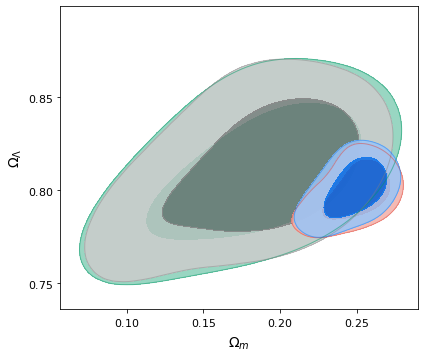

In [36]:
import getdist.plots
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAO,posteriorBAOR,posteriorTot,posteriorTotR], ('om','ol'),filled=True)
#g.export('OmOk_fs.pdf')

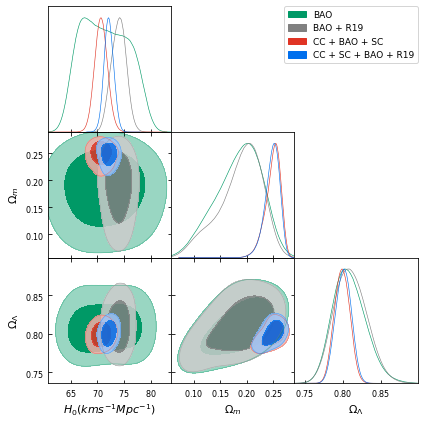

In [37]:
g = getdist.plots.getSubplotPlotter()
g.triangle_plot([posteriorBAO,posteriorBAOR,posteriorTot,posteriorTotR], ('h0','om','ol') ,filled=True, legend_labels=[r'BAO',r'BAO + R19',r'CC + BAO + SC',r'CC + SC + BAO + R19'])
#g.export('LCDMrdk_fs.pdf')

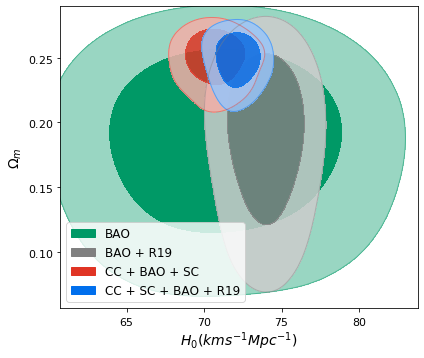

In [38]:
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAO,posteriorBAOR,posteriorTot,posteriorTotR], ('h0','om'),filled=True)
g.add_legend([r'BAO',r'BAO + R19',r'CC + BAO + SC',r'CC + SC + BAO + R19'], legend_loc='lower left')
#g.export('Omh0k_fs.pdf')

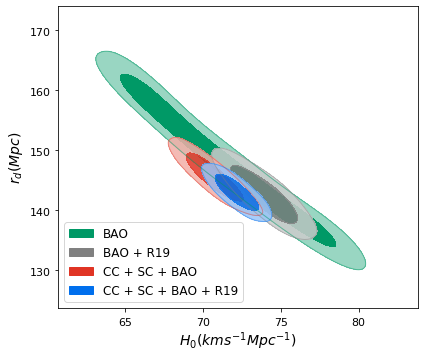

In [39]:
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAO,posteriorBAOR,posteriorTot,posteriorTotR], ('h0','rd'),filled=True)
g.add_legend([r'BAO',r'BAO + R19',r'CC + SC + BAO',r'CC + SC + BAO + R19'], legend_loc='lower left')
#g.export('h0rdk_fs.pdf')

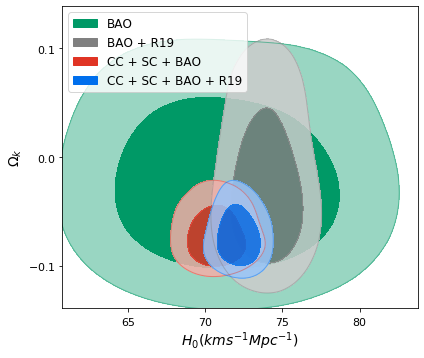

In [40]:
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAO,posteriorBAOR,posteriorTot,posteriorTotR], ('h0','ok'),filled=True)
g.add_legend([r'BAO',r'BAO + R19',r'CC + SC + BAO',r'CC + SC + BAO + R19'], legend_loc='upper left')
#g.export('h0ok_Omk_fs.pdf')

((60.70057883127271, 83.771410136548),
 (-0.13890338622709153, 0.13850592014023422))

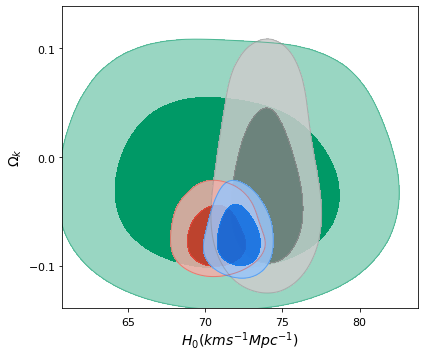

In [41]:
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAO,posteriorBAOR,posteriorTot,posteriorTotR], ('h0','ok'),filled=True)
#g.add_legend([r'BAO',r'BAO + R19',r'CC + SC + BAO',r'CC + SC + BAO + R19'], legend_loc='upper left')
#g.export('h0ok_Omk_fs.pdf')

((60.70057883127271, 83.771410136548),
 (-0.13890338622709153, 0.13850592014023422))

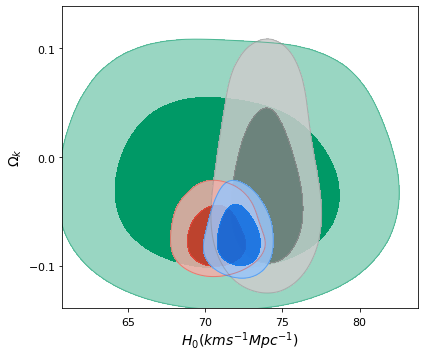

In [42]:
%matplotlib inline
g = plots.get_single_plotter(width_inch=6, ratio=1/1.18)
g.plot_2d([posteriorBAO,posteriorBAOR,posteriorTot,posteriorTotR], ('h0','ok'),filled=True)
#g.export('h0ok_Omk_fs.pdf')

In [50]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        #print("\nupper limit 95 C.L. = %f" % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        #print("lower limit 95 C.L. = %f" % lower)
        print("%s = %f +/- %f +/- %f" % (samples.parLabel(i),\

        mean, mean - samples.confidence(i, limfrac=0.16),\
        mean - samples.confidence(i, limfrac=0.025)) )
    return
for i in ["BAO","BAOR", "Tot", "TotR"]:
    print(i)
    get_constraints(eval("posterior"+i))

BAO
H_0 (km s^{-1} Mpc^{-1}) = 71.368953 +/- 5.019894 +/- 6.673367
\Omega_k = -0.022455 +/- 0.051389 +/- 0.073920
\Omega_m = 0.185385 +/- 0.047728 +/- 0.087491
\Omega_\Lambda = 0.808443 +/- 0.020972 +/- 0.038304
r_d (Mpc) = 148.140612 +/- 10.301046 +/- 14.288939
rat = 0.998952 +/- 0.070940 +/- 0.095155
L = 13.623840 +/- 1.588232 +/- 2.400265
L/Dof = 1.238531 +/- 0.144385 +/- 0.218206
p = 0.268133 +/- 0.096127 +/- 0.178301
BAOR
H_0 (km s^{-1} Mpc^{-1}) = 73.968817 +/- 1.457954 +/- 2.665858
\Omega_k = -0.026658 +/- 0.046532 +/- 0.067656
\Omega_m = 0.188413 +/- 0.042007 +/- 0.090922
\Omega_\Lambda = 0.810126 +/- 0.021516 +/- 0.039317
r_d (Mpc) = 142.463421 +/- 3.080991 +/- 5.708177
rat = 0.961019 +/- 0.019986 +/- 0.040265
L = 13.635102 +/- 1.577019 +/- 2.335823
L/Dof = 1.239555 +/- 0.143365 +/- 0.212348
p = 0.266793 +/- 0.092561 +/- 0.176606
Tot
H_0 (km s^{-1} Mpc^{-1}) = 70.686810 +/- 1.144414 +/- 2.263346
\Omega_k = -0.072537 +/- 0.019007 +/- 0.025674
\Omega_m = 0.249768 +/- 0.015141 +/

In [65]:
def AIC_chi2(chi2, p, n):
    return [chi2+2*p,chi2+2*p+2*p*(p+1)/(n-p-1)]
def BIC_chi2(chi2, p, n):
    return chi2+p*np.log10(n)
L1=260.140535
n1=273
p=6
AIC_chi2(L1,p,n1), BIC_chi2(L1,p,n1)

([272.140535, 272.4563244736842], 274.75751088224456)

In [48]:
import getdist.mcsamples
#help(getdist.mcsamples)
for i in ["BAO","BAOR", "Tot", "TotR"]:
    print(eval("posterior"+i).getNumSampleSummaryText())
    print('Marginalised evidence is {} ± {}'.format(eval("output"+i).logZ, eval("output"+i).logZerr))

using 1715 rows, 9 parameters; mean weight 0.2525920506573149, tot weight 433.19536687729504
Equiv number of single samples (sum w)/max(w): 433.0
Effective number of weighted samples (sum w)^2/sum(w^2): 643

Marginalised evidence is -26.7167703191202 ± 0.360089937995294
using 1664 rows, 9 parameters; mean weight 0.25231316620250827, tot weight 419.8491085609737
Equiv number of single samples (sum w)/max(w): 420.0
Effective number of weighted samples (sum w)^2/sum(w^2): 630

Marginalised evidence is -25.4479319978604 ± 0.342222314285855
using 1988 rows, 9 parameters; mean weight 0.12341779181938542, tot weight 245.3545701369382
Equiv number of single samples (sum w)/max(w): 245.0
Effective number of weighted samples (sum w)^2/sum(w^2): 657

Marginalised evidence is -277.374939545804 ± 0.412356670465258
using 2095 rows, 9 parameters; mean weight 0.22082036922509365, tot weight 462.61867352657123
Equiv number of single samples (sum w)/max(w): 463.0
Effective number of weighted samples (su

In [1]:
#outputBAO

In [2]:
#outputBAOR

In [3]:
#outputTot

In [4]:
#outputTotR